# Tiền xử lý dữ liệu văn bản

#### Import thư viện

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import random
import math
import os
from tqdm.notebook import tqdm
import pickle

#### Load dữ liệu

Thông tin bộ dữ liệu

![alt text](image/stats.png)

In [2]:
train_x = pickle.load(open('Data/train_x_raw.sav', 'rb'))
train_y = pickle.load(open('Data/train_y_raw.sav', 'rb'))
test_x = pickle.load(open('Data/test_x_raw.sav', 'rb'))
test_y = pickle.load(open('Data/test_y_raw.sav', 'rb'))

In [3]:
labels = list(np.unique(train_y))

In [4]:
labels

['Am nhac',
 'Am thuc',
 'Bat dong san',
 'Bong da',
 'Chung khoan',
 'Cum ga',
 'Cuoc song do day',
 'Du hoc',
 'Du lich',
 'Duong vao WTO',
 'Gia dinh',
 'Giai tri tin hoc',
 'Giao duc',
 'Gioi tinh',
 'Hackers va Virus',
 'Hinh su',
 'Khong gian song',
 'Kinh doanh quoc te',
 'Kinh te',
 'Lam dep',
 'Loi song',
 'Mua sam',
 'My thuat',
 'San khau dien anh',
 'San pham tin hoc moi',
 'Suc khoe',
 'Tennis',
 'The gioi tre',
 'Thoi trang',
 'Xe co']

In [6]:
label_len = {}
for label in labels:
    label_len[label] = np.count_nonzero(train_y == label)
label_len

{'Am nhac': 1296,
 'Am thuc': 528,
 'Bat dong san': 458,
 'Bong da': 2567,
 'Chung khoan': 513,
 'Cum ga': 661,
 'Cuoc song do day': 1174,
 'Du hoc': 765,
 'Du lich': 1102,
 'Duong vao WTO': 289,
 'Gia dinh': 375,
 'Giai tri tin hoc': 1328,
 'Giao duc': 1348,
 'Gioi tinh': 446,
 'Hackers va Virus': 489,
 'Hinh su': 395,
 'Khong gian song': 150,
 'Kinh doanh quoc te': 985,
 'Kinh te': 540,
 'Lam dep': 1077,
 'Loi song': 425,
 'Mua sam': 206,
 'My thuat': 259,
 'San khau dien anh': 1667,
 'San pham tin hoc moi': 1093,
 'Suc khoe': 165,
 'Tennis': 630,
 'The gioi tre': 759,
 'Thoi trang': 542,
 'Xe co': 212}

In [21]:
# Test dữ liệu đã load được
random_list = random.sample(range(0, len(train_x) - 1), 5)
for i in random_list:
    print("Cate: ", train_y[i])
    print("Content: ", train_x[i])
    print('-------------------------------')

Cate:  Tennis
Content:  Tim Henman 'mất điểm' trước người hâm mộ 
Được mời tới thăm trường tiểu học Jumeirah trong thời gian tham dự giải Dubai Mở rộng, nhưng tay vợt người Anh Tim Henman đã từ chối thực hiện nghĩa vụ của mình sau khi thất bại ở ngay vòng một. Không có một sự giải thích hợp lý nào, và ATP đã phải cử Federer thay thế. 
Henman được mời thăm trường tiểu học Jumeirah sau khi Emily Kirton - một cậu bé 8 tuổi - giành giải nhất cuộc thi viết về thần tượng của mình do nhà trường tổ chức. Cuộc thi do BTC giải Dubai Mở rộng tài trợ. Và Tim Henman, người xuất hiện trong bài viết này, sẽ có chuyến thăm trường theo sự sắp xếp của BTC giải. 
Tuy nhiên, sau khi để thua tay vợt phải qua đấu loại người CH Czech hạng 149 thế giới tối thứ hai, Henman cho biết anh không thể thực hiện chuyến thăm trường Jumeirah vì đã đặt vé cho chuyến bay trở về Anh vào 2h45 sáng hôm sau.
Sáng thứ ba, toàn bộ học sinh và các bậc phụ huynh đã vô cùng thất vọng khi hiệu trưởng nhà trường thông báo quyết địn

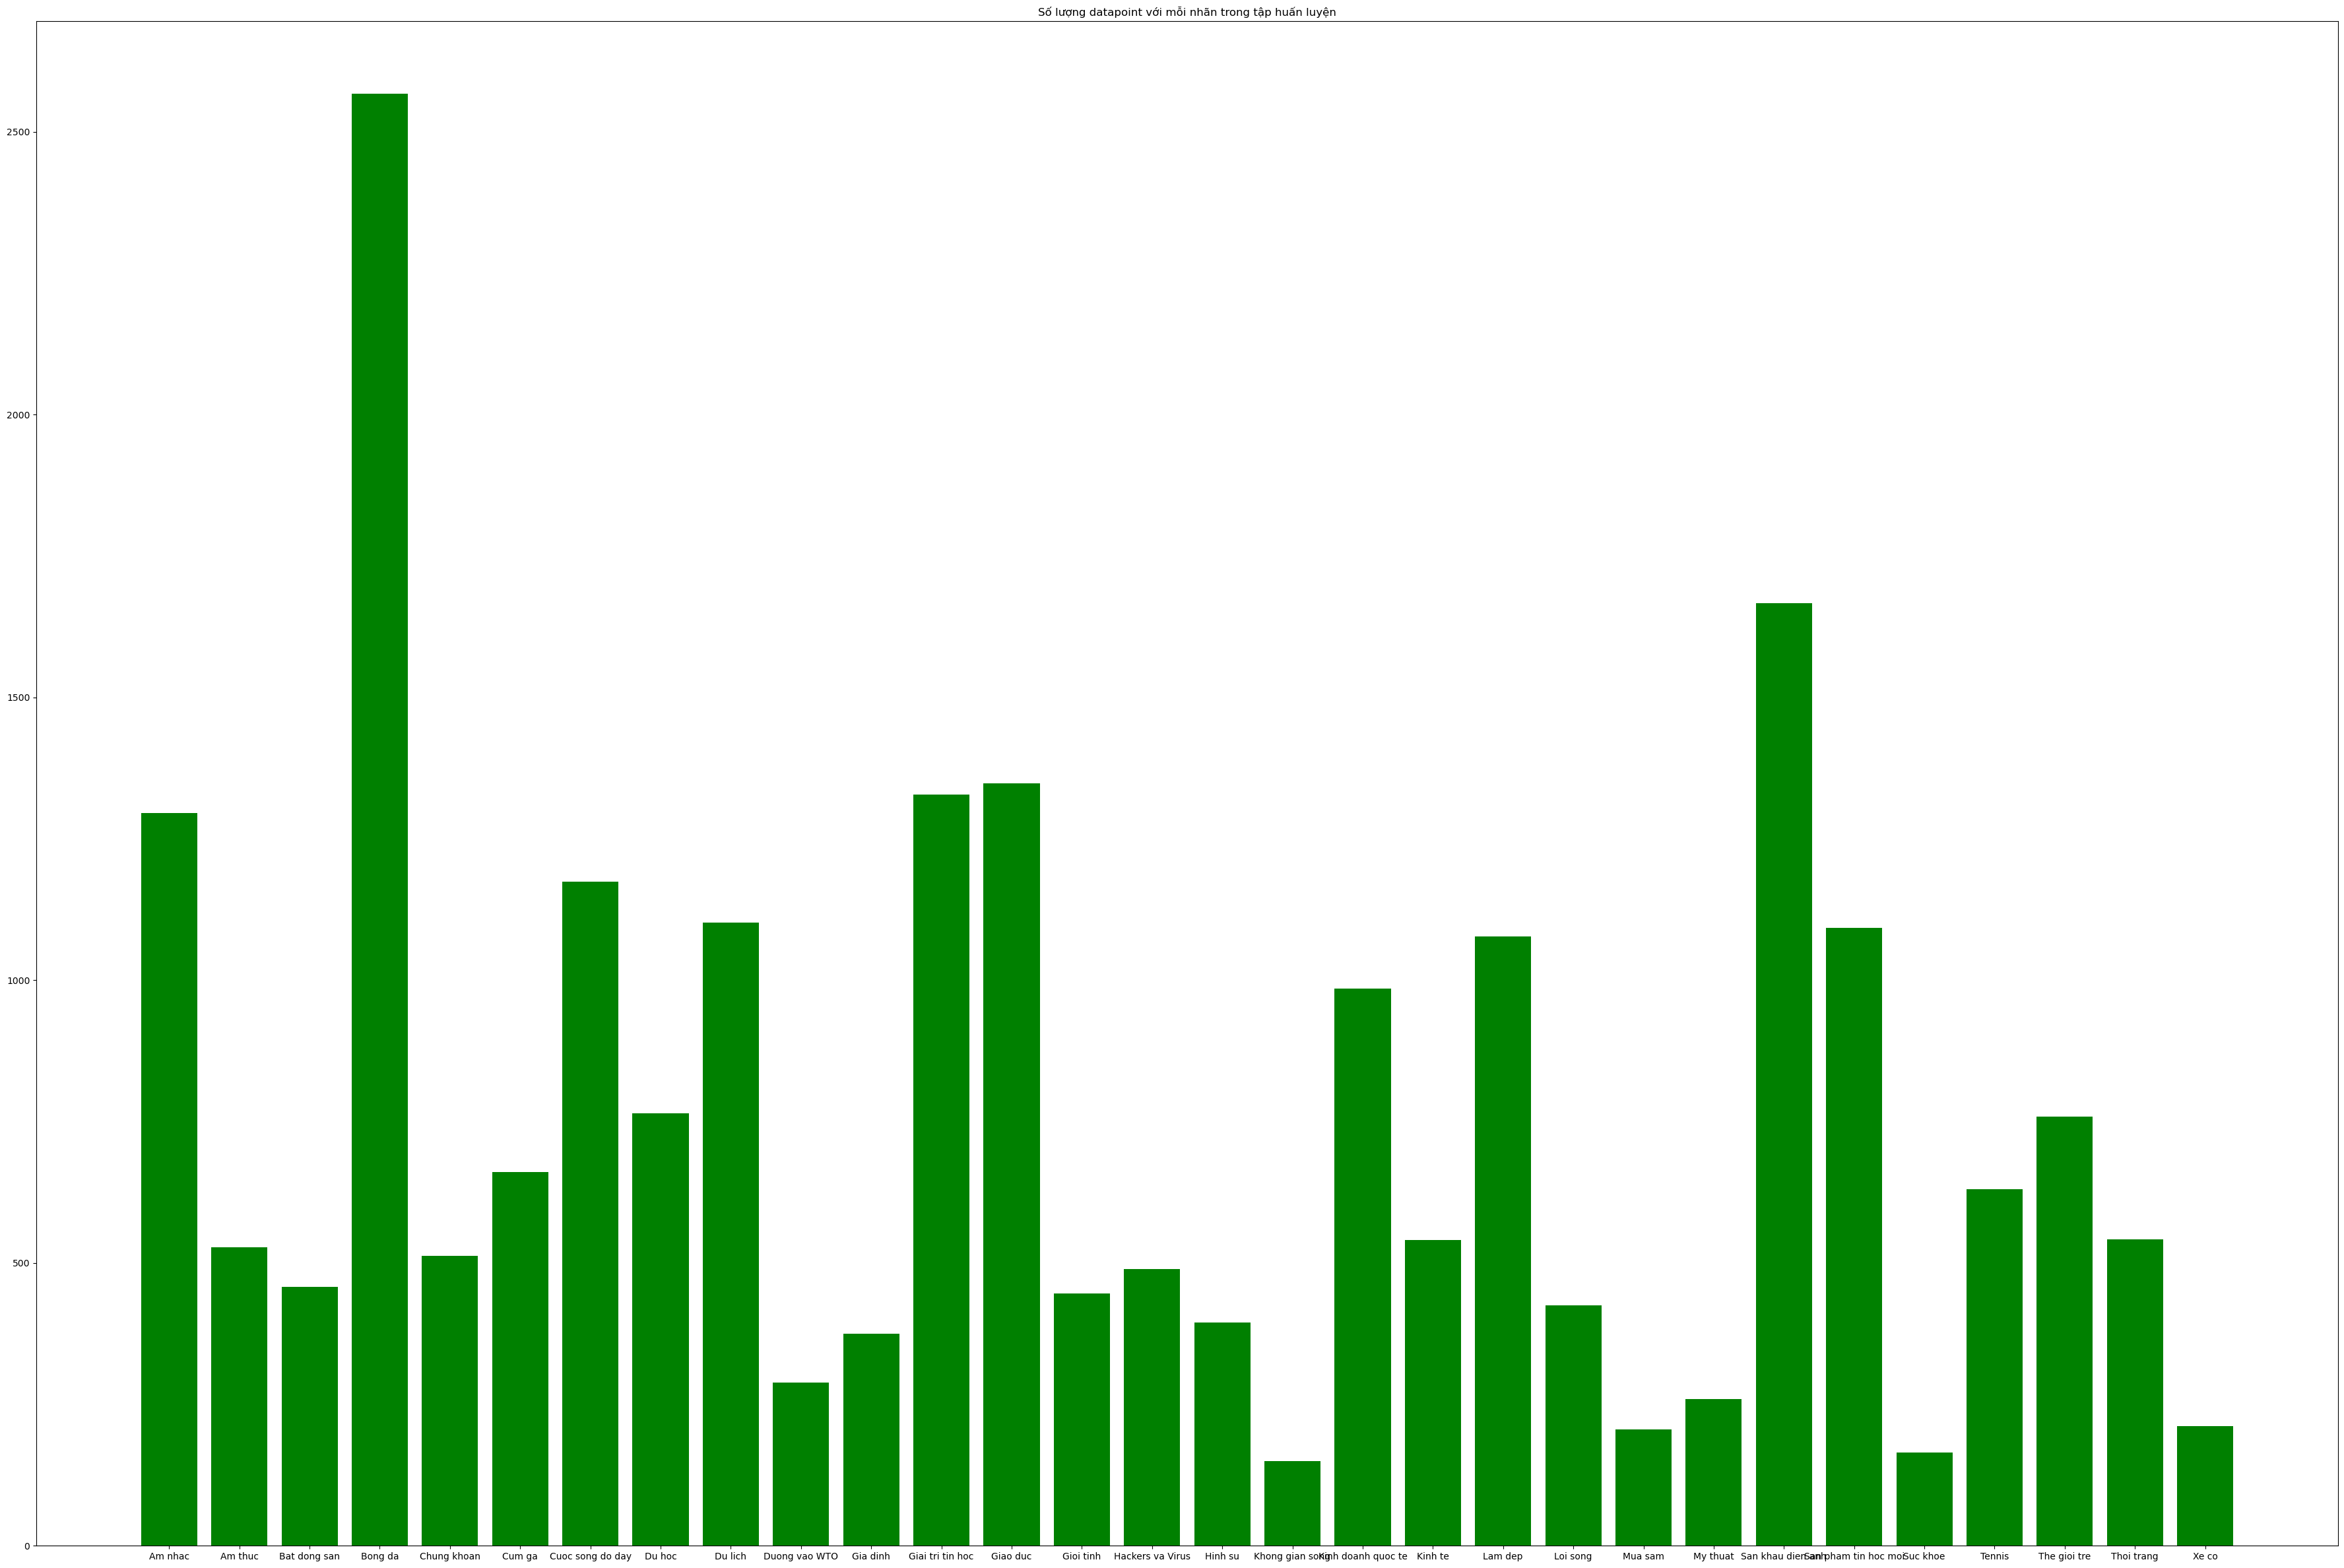

In [25]:
plt.figure(figsize=(45,30))
plt.title('Số lượng datapoint với mỗi nhãn trong tập huấn luyện')
plt.bar(list(label_len.keys()), label_len.values(), color='g')
plt.show()

### Đánh giá sơ bộ tập dữ liệu

In [22]:
# Tính độ dài trung bình của tập dữ liệu
def sentence_len(text):
    return len(text.split(" "))

len_list = []

for content in train_x:
    len_list.append(sentence_len(content))

print('Độ dài trung bình:', np.mean(len_list))

Độ dài trung bình: 530.2749509891285


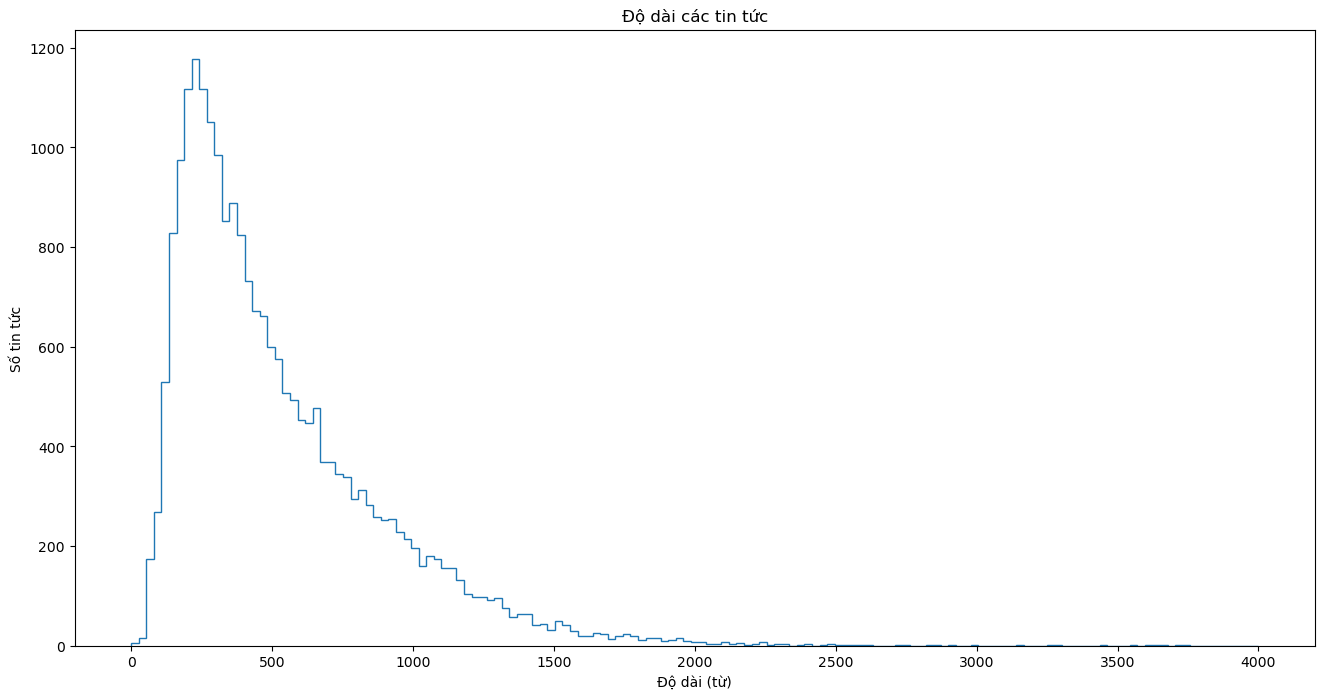

In [23]:
# Vẽ biểu đồ để quan sát phân bố độ dài của từng văn bản
plt.figure(figsize=(16,8))
plt.title("Độ dài các tin tức")
plt.xlabel("Độ dài (từ)")
plt.ylabel("Số tin tức")
plt.hist(np.array(len_list), bins=int(math.sqrt(len(len_list))), histtype='step', range=(0, 4000))
plt.savefig('image/dataset_before_preprocess.png', facecolor='whitesmoke', bbox_inches='tight')
plt.show()

## Tiền xử lý gồm những việc sau:
- Xoá HTML code
- Chuẩn hóa bảng mã Unicode
- Chuẩn hóa kiểu gõ dấu tiếng Việt (dùng òa úy thay cho oà uý)
- Đưa văn bản về dạng viết thường
- Thực hiện tách từ tiếng Việt
- Xóa các ký tự đặc biệt
- Loại bỏ stopwords

#### 1. Xoá HTML code
Dữ liệu thu thập từ các trang web có thể có những đoạn mã HTML. Những đoạn mã này không được sử dụng và làm kém chất lượng của dữ liệu.
Để xoá những đoạn mã HTML, ta dùng regex (Regular Expression) trong Python.

In [19]:
import re
# hàm xoá html code
def remove_html(txt):
    return re.sub(r'<[^>]*>', '', txt)

#ví dụ
txt = "<p class=\"par\">Đây là 1 ví dụ xoá html code</p>"
remove_html(txt)

'Đây là 1 ví dụ xoá html code'

#### 2. Chuẩn hoá bảng mã Unicode
Hiện nay, có 2 loại mã Unicode được sử dụng phổ biến, **Unicode tổ hợp** và **Unicode dựng sẵn**. Việc sử dụng 2 loại mã khác nhau sẽ dẫn đến kết quả khác nhau.
Ví dụ

In [19]:
'hiếu' == 'hiếu'

True

In [20]:
'hiếu' == 'hiếu'

False

Để giải quyết vấn đề này, ta đưa tất cả dữ liệu về loại mã **Unicode dựng sẵn** vì nó khá phổ biến

In [8]:
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

# Hàm tạo dict để chuyển định dạng
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)
 

In [9]:
#Thử nghiệm
type1 = 'hiếu' # Loại dựng sẵn
type2 = 'hiếu' # Loại tổ hợp

print(type1 == type2)
# Nếu là loại dựng sẵn thì không thay đổi
print(type1 == convert_unicode(type1))
# Nếu là loại tổ hợp thì sẽ đưa về loại dựng sẵn
print(type1 == convert_unicode(type2))

False
True
True


#### 3. Chuẩn hoá kiểu gõ dấu và đưa về dạng viết thường
  Bằng mắt thường, ta cũng có thể phân biệt được hai kiểu gõ dấu: **oà** và **òa**, lần lượt là kiểu gõ mới và cũ (phổ biến hơn). Lỗi gõ dấu thường xảy ra là do cách đánh máy của người viết báo, do khác bộ mã hoặc đôi khi nó thường xuất hiện trong các văn bản cũ. Tuy nhiên việc khác bộ mã đã được xử lý ở trên, do đó, ở phần này, ta sẽ sửa những kiểu gõ dấu tiếng Việt khác nhau về kiểu cũ (phổ biến hơn): **òa**

Việc đưa các từ trong câu về chữ viết thường là rất cần thiết. Bởi vì đặc trưng này không có tác dụng ở bài toán phân loại văn bản. Đưa về chữ viết thường giúp giảm số lượng đặc trưng phải học (vì máy hiểu chữ hoa chữ thường là 2 chữ khác nhau) và tăng độ chính xác hơn cho mô hình.

In [10]:
# Danh sách nguyên âm và các dấu
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
# Danh sách dấu tương ứng với danh sách nguyên âm bên trên
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

# Chuyển ký tự sang chỉ số (i, j), trong đó i là nguyên âm và j là dấu tương ứng
nguyen_am_to_ids = {}

# Tạo dict
for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)
nguyen_am_to_ids['à']

# Kiểm tra tính hợp lệ của từ trong tiếng Việt
# Các nguyên âm sẽ đứng cạnh nhau tạo thành cụm, và mỗi từ tối đa 1 cụm nguyên âm
# Nguyên->Ng(uyê)n, Chào->Ch(ào), Ngủ->Ng(ủ)
def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    
    # Duyệt từng ký tự trong một từ
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1)) # x xác định nguyên âm, y xác định dấu
        if x != -1: # Nếu char là nguyên âm
            if nguyen_am_index == -1: # Nếu chưa tìm thấy nguyên âm
                nguyen_am_index = index
            else: # Nếu đã tìm thấy nguyên âm
                if index - nguyen_am_index != 1: # Nếu nguyên âm không đứng cạnh nguyên âm đã tìm thấy
                    return False
                nguyen_am_index = index
    return True

print(is_valid_vietnam_word('Hello'))
print(is_valid_vietnam_word('Nguyên'))

False
True


In [12]:
def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word): # Không phải từ tiếng việt sẽ không xử lý và trả lại.
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    
    for index, char in enumerate(chars): # Duyệt từng ký tự
        x, y = nguyen_am_to_ids.get(char, (-1, -1))

        if x == -1: # Nếu ký tự là phụ âm
            continue
        elif x == 9:  # check "qu"
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check "gi"
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        
        if y != 0: # Nếu có dấu
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0] # Bỏ dấu
        
        # Nếu không phải trường hợp 'qu' hoặc 'gi' hoặc là index khác 1 (nguyên âm từ ký tự thứ 3 trở đi)
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
        else:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    return ''.join(chars)

# Chuẩn hoá dấu câu cho cả câu và đưa về dạng viết thường
def chuan_hoa_dau_cau_tieng_viet(sentence):
    sentence = sentence.lower() # Chuyển về dạng viết thường
    words = sentence.split()
    
    # Xử lý trên từng từ
    for index, word in enumerate(words):
        cw = re.sub(r'(^\\p{P}*)([p{L}.]*\\p{L}+)(\\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

print(chuan_hoa_dau_cau_tieng_viet("Hai đội đã hoà nhau. Trận đấu rất hay! Quá tuyệt vời!"))

hai đội đã hoà nhau. trận đấu rất hay! quá tuyệt vời!


#### 4. Tách từ tiếng việt

Đơn vị từ trong tiếng việt gồm từ đơn (học) và từ ghép (học sinh). Ta phải xử lý để mô hình học máy cần phân biệt được từ đơn và từ ghép. Nếu không, đối với máy tất cả đều là từ đơn.

Mô hình học sẽ coi các từ là đặc trưng, phân tách bởi dấu cách. Ta cần phải nối các từ ghép lại

Ví dụ: Học sinh học sinh học -> Học_sinh học sinh_học

Bài toán này là một bài toán cơ sở trong NLP. Hiện nay có khá nhiều thư viện mã nguồn mở giải quyết bài toán này như **underthesea** và **pyvi**. Trong bài này, ta sẽ sử dụng thư viện **underthesea**

In [13]:
# Import thư viện underthesea
from underthesea import word_tokenize

# Ví dụ
sentence = "Chàng trai 2000 Hải Dương khởi nghiệp từ nghề ve chai, sau 10 năm, anh ấy thành vua ve chai"
print(word_tokenize(sentence))
print(word_tokenize(sentence, format="text"))

['Chàng', 'trai', '2000', 'Hải Dương', 'khởi nghiệp', 'từ', 'nghề', 've chai', ',', 'sau', '10', 'năm', ',', 'anh', 'ấy', 'thành', 'vua', 've chai']
Chàng trai 2000 Hải_Dương khởi_nghiệp từ nghề ve_chai , sau 10 năm , anh ấy thành vua ve_chai


#### 5. Xoá các ký tự không cần thiết

Việc loại bỏ các ký tự không cần thiết giúp:
- Giảm số chiều đặc trưng, tăng tốc độc học và xử lý
- Tránh gây nhiễu, ảnh hưởng xấu tới kết quả mô hình

Loại các dấu ngắt câu, các ký tự đặc biệt

In [14]:
def remove_unnecessary_character(document):
    # Xoá các ký tự không cần thiết
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    # Xoá khoảng trắng thừa
    document = re.sub(r'\s+', ' ', document).strip()
    return document

In [15]:
sentence = "Xin chào! Tôi tên là Nguyễn Văn A. Ngày hôm nay của bạn thế nào?"
remove_unnecessary_character(sentence)

'Xin chào Tôi tên là Nguyễn Văn A Ngày hôm nay của bạn thế nào'

#### 6. Tổng hợp các bước trên

In [16]:
def text_preprocessing(document):
    # Xoá html code
    document = remove_html(document)
    # Chuẩn hóa unicode
    document = convert_unicode(document)
    # Chuẩn hóa cách gõ dấu tiếng Việt và đưa về dạng viết thường
    document = chuan_hoa_dau_cau_tieng_viet(document)
    # Tách từ
    document = word_tokenize(document, format="text")
    # Xóa các ký tự không cần thiết và khoảng trắng thừa
    document = remove_unnecessary_character(document)
    return document

In [18]:
# Kiểm tra
document = """
Tối 19/4, đồng chí Lê Minh Khái, Bí thư Trung ương Đảng, Phó Thủ tướng Chính phủ đã dự và phát biểu tại Lễ xuất quân của Đoàn Thể thao Việt Nam tham dự SEA Games 32.
Phát biểu tại sự kiện, đồng chí Lê Minh Khái bày tỏ: ""Trong không khí cả nước hân hoan chào mừng kỷ niệm 48 năm Ngày Giải phóng miền Nam, thống nhất đất nước, hôm nay, chúng ta hết sức vui mừng cùng có mặt dự Lễ xuất quân Đoàn Thể thao Việt Nam tham dự SEA Games lần thứ 32, được tổ chức tại nước bạn láng giềng anh em Campuchia, đây là một trong những nhiệm vụ quan trọng nhất của thể thao Việt Nam trong năm nay"".
Thay mặt Lãnh đạo Đảng, Nhà nước, đồng chí Lê Minh Khái gửi tới toàn thể các cán bộ, huấn luyện viên, vận động viên, các chuyên gia của Đoàn thể thao Việt Nam và toàn thể quý vị đại biểu lời chúc tốt đẹp nhất, chúc Đoàn Thể thao Việt Nam thi đấu thành công tại SEA Games lần này!
Đồng chí Lê Minh Khái nhấn mạnh: Thể dục thể thao giữ vị trí quan trọng góp phần nâng cao sức khỏe và chất lượng cuộc sống của nhân dân, xây dựng đời sống và môi trường văn hóa lành mạnh; củng cố khối đại đoàn kết toàn dân, đóng góp vào công cuộc bảo vệ, xây dựng và phát triển đất nước; mở rộng quan hệ hữu nghị và hợp tác quốc tế của đất nước ta.
Bên cạnh việc chăm lo phát triển sự nghiệp thể dục thể thao quần chúng, trong những năm gần đây, Đảng, Nhà nước và toàn xã hội ngày càng quan tâm tới công tác đào tạo vận động viên và phát triển thể thao thành tích cao.
Việc cử Đoàn Thể thao Việt Nam tham dự các Đại hội thể thao quốc tế, trong đó có SEA Games, thể hiện sự quan tâm sâu sắc của Đảng, Nhà nước và nhân dân đối với lĩnh vực thể dục thể thao nước nhà.
Theo đồng chí Lê Minh Khái: SEA Games không chỉ đơn thuần là sự kiện thể thao của các quốc gia trong khu vực Đông Nam Á, là cơ hội để các đoàn vận động viên đến từ 11 quốc gia khu vực Đông Nam Á thể hiện tài năng, nâng cao thành tích thể thao của mình, mà còn là ngày hội thể hiện tình đoàn kết, hữu nghị, giao lưu văn hóa giữa các quốc gia trong khu vực.
Nhắc lại cách đây tròn 1 năm, Lễ xuất quân của Đoàn Thể thao Việt Nam tham dự SEA Games 31 được tổ chức trọng thể, đồng chí Lê Minh Khái nhấn mạnh: SEA Games 31 tổ chức tại nước ta đã thành công về nhiều mặt, lan tỏa tích cực, bất chấp mọi khó khăn trong quá trình chuẩn bị do dịch bệnh; đã được các cấp có thẩm quyền và xã hội ghi nhận, biểu dương, khen thưởng kịp thời và xứng đáng.
Thời gian qua, Đoàn Thể thao Việt Nam với 1003 thành viên, trong đó có 702 vận động viên, 189 huấn luyện viên đã khắc phục mọi khó khăn, miệt mài rèn luyện để chuẩn bị tham dự 30/36 môn thể thao với 447/583 nội dung thi đấu tại SEA Games 32, phấn đấu duy trì vị trí ở tốp đầu.
Đồng chí Lê Minh Khái tin tưởng rằng: Mặc dù lần này chúng ta không có nhiều thuận lợi như SEA Games 31 nhưng với vị thế, khả năng của thể thao Việt Nam trong khu vực (luôn trong tốp đầu từ SEA Games 22 đến nay), cơ hội có thể đạt được mục tiêu đặt ra, thậm chí có thể ở mức cao.
""Tôi biết rằng tất cả thành viên của Đoàn nhận thức rõ được vinh dự và trách nhiệm, đã và đang phấn đấu, nỗ lực với tinh thần phát huy cao nhất những thành tích đã đạt được trong thời gian qua"", đồng chí Lê Minh Khái bày tỏ.Thay mặt lãnh đạo Đảng, Nhà nước, đồng chí Lê Minh Khái ghi nhận và đánh giá cao sự nỗ lực, cố gắng của các vận động viên, huấn luyện viên, chuyên gia của Đoàn Thể thao Việt Nam.
Với niềm vinh dự được Đảng, Nhà nước và Nhân dân giao phó, phát huy những thành công của Thể thao Việt Nam đã đạt được trong những năm qua, đặc biệt là những thành công vượt bậc tại SEA Games 31 gần đây nhất, mỗi thành viên của Đoàn Thể thao Việt Nam tham dự SEA Games 32 phải nhận thức được trách nhiệm vẻ vang của mình, cần thể hiện tốt truyền thống văn hóa và lan tỏa những giá trị tốt đẹp của đất nước đến bạn bè quốc tế; tăng cường tinh thần đoàn kết hữu nghị, giao lưu học tập kinh nghiệm với các đoàn bạn. 
Mỗi một cá nhân của đoàn thể thao Việt Nam là một ""Đại sứ văn hóa"" của đất nước.
Đồng chí Lê Minh Khái nhấn mạnh: Các thành viên của Đoàn cần đoàn kết, khắc phục khó khăn, giữ vững kỷ luật, đem hết tinh thần và nghị lực để hoàn thành nhiệm vụ đã đề ra; thi đấu với tinh thần thể thao cao thượng, ngoan cường, sáng tạo, trung thực để đạt thành tích cao nhất tại đại hội, góp phần nâng vị thế của thể thao Việt Nam lên một tầm cao mới, khẳng định được truyền thống văn hóa lâu đời của Việt Nam. Tôn trọng luật lệ thi đấu, tôn trọng truyền thống văn hóa của các nước tham dự.
Một lần nữa, đồng chí Lê Minh Khái chúc Đoàn Thể thao Việt Nam thi đấu thành công, giành được nhiều thành tích xuất sắc tại SEA Games lần thứ 32!Tại buổi lễ, Tổng cục trưởng Tổng cục Thể dục Thể thao, Trưởng Đoàn thể thao Việt Nam dự SEA Games 32, ông Đặng Việt Hà cho biết: Đoàn Thể thao Việt Nam phấn đấu đạt từ 89 đến 120 huy chương vàng, đứng Top đầu các quốc gia tham dự, duy trì thứ hạng cao ở các môn thể thao Olympic.
Toàn thể cán bộ, huấn luyện viên, chuyên gia, vận động viên của Đoàn Thể thao Việt Nam xin nhận nhiệm vụ trước Đảng, Nhà nước và nhân dân sẽ cố gắng nỗ lực thi đấu hết mình, bình tĩnh, tự tin, mưu trí, sáng tạo, thi đấu ngoan cường, giành từng huy chương về cho Đoàn và Tổ quốc.
Đồng thời, mỗi thành viên của Đoàn sẽ thể hiện tốt vai trò là sứ giả hòa bình, góp phần giữ vững, tăng cường tình đoàn kết, hữu nghị hợp tác và phát triển với các quốc gia Đông Nam Á.
Ông Đoàn Việt Hà nhấn mạnh: ""Đoàn Thể thao Việt Nam đã sẵn sàng, các vận động viên đã sẵn sàng và chúng tôi luôn tự ý thức được sứ mệnh của mình là vì ""màu cờ, sắc áo"", vì trách nhiệm trước Tổ quốc và Nhân dân"".
Thay mặt Đoàn Thể thao Việt Nam, ông Đoàn Việt Hà bày tỏ lời cảm ơn chân thành tới các đồng chí lãnh đạo Đảng, Nhà nước, Quốc hội, Chính phủ. 
Sự quan tâm của các đồng chí lãnh đạo cùng toàn thể nhân dân sẽ tạo niềm tin mạnh mẽ, tiếp sức cho Đoàn trên con đường thực hiện mục tiêu đề ra./.Trần Mạnh
"""
document = text_preprocessing(document)
print(document)

tối 194 đồng_chí lê_minh khái bí_thư trung_ương đảng phó_thủ_tướng chính_phủ đã dự và phát_biểu tại lễ xuất_quân của đoàn thể_thao việt nam tham_dự sea_games 32 phát_biểu tại sự_kiện đồng_chí lê_minh khái bày_tỏ trong không_khí cả nước hân_hoan chào_mừng kỷ_niệm 48 năm ngày giải_phóng miền nam thống_nhất đất_nước hôm_nay chúng_ta hết_sức vui_mừng cùng có_mặt dự lễ xuất_quân_đoàn thể_thao việt nam tham_dự sea games lần thứ 32 được tổ_chức tại nước bạn láng_giềng anh_em campuchia đây là một trong những nhiệm_vụ quan_trọng nhất của thể_thao việt nam trong năm nay thay_mặt lãnh_đạo đảng nhà_nước đồng_chí lê_minh khái gửi tới toàn_thể các cán_bộ huấn_luyện_viên vận_động_viên các chuyên_gia của đoàn thể_thao việt nam và toàn_thể quý vị đại_biểu lời_chúc tốt_đẹp nhất chúc đoàn thể_thao việt nam thi_đấu thành_công tại sea games lần này đồng_chí lê_minh khái nhấn_mạnh thể_dục thể_thao giữ vị_trí quan_trọng góp_phần nâng cao sức_khỏe và chất_lượng cuộc_sống của nhân_dân xây_dựng đời_sống và môi_

In [26]:
# Thực hiện xử lý trên toàn bộ dữ liệu
print('Xử lý dữ liệu trên tập train...')
for i, news in enumerate(tqdm(train_x)):
  train_x[i] = text_preprocessing(news)

print('Xử lý dữ liệu trên tập test...')
for i, news in enumerate(tqdm(test_x)):
  test_x[i] = text_preprocessing(news)

Xử lý dữ liệu trên tập train...


  0%|          | 0/22444 [00:00<?, ?it/s]

Xử lý dữ liệu trên tập test...


  0%|          | 0/9620 [00:00<?, ?it/s]

In [27]:
# Kiểm tra
train_x[1]

'chuyến phà từ ozu sẽ đưa du_khách đến đảo aoshima thuộc tỉnh ehime trong vòng 20 phút hòn đảo dân_cư thưa_thớt đã trở_thành điểm thu_hút khách du_lịch đông_đúc nhưng không có cửa_hàng khách_sạn hay nhà_hàng nào ở đây những gì aoshima có là mèo rất rất nhiều mèo người_ta từng đếm có hơn 200 con mèo sinh_sống trên hòn đảo nhỏ_bé có chiều dài chỉ 1 6 km này rộng cả_thảy 46 ha và dân_số mèo đang tăng không ngừng hàng ngày trước đây tôi hiếm khi chở khách du_lịch phà trưởng nobuyuki ninomiya nói với báo_chí bây_giờ tôi chở khách du_lịch mỗi tuần mặc_dù sản_phẩm du_lịch duy_nhất chúng_tôi có là mèo những con mèo đã quen với con_người và do_đó được coi là bán hoang_dã chúng vui_vẻ chơi_đùa với du_khách và thậm_chí còn có khu_vực cho ăn được chỉ_định gần trung_tâm cộng_đồng nhưng làm thế_nào mà hòn đảo xa_xôi này trở_nên tràn_ngập mèo ngư_dân xưa_kia đã mang những con mèo đi lạc đến hòn đảo này để diệt_chuột và không có kẻ săn mồi nào khác đe_dọa mèo đã sinh_sản con đàn cháu đống mà không gặp

In [30]:
type(train_x)

numpy.ndarray

#### 7. Loại bỏ stop word tiếng Việt

- Stopword là các từ xuất hiện nhiều ở tất cả các chuyên mục cần phân loại. Do đó, chúng là các đặc trưng không có tác dụng cho việc phân loại văn bản.
- Các stopword thường là các từ nối (của, là, có, được, những,…) và các từ đặc trưng của dữ liệu (ví dụ như các từ “máy bay, tiếp viên” là các stopword nếu làm bài phân loại đánh giá khách hàng của doanh nghiệp vận tải hàng không).

In [31]:
# Thống kê các từ và số lượng tương ứng
count = {}
print('Processing news ...')
for content in (train_x):
  words = content.split(' ')
  for word in words:
    if word not in count:
      count[word] = 1
    else:
      count[word] += 1

for content in (test_x):
  words = content.split(' ')
  for word in words:
    if word not in count:
      count[word] = 1
    else:
      count[word] += 1

print('Number of words in dataset: ', len(count))

Processing news ...
Number of words in dataset:  136611


In [32]:
# Liệt kê 100 từ xuất hiện nhiều nhất
sorted_count = sorted(count, key=count.get, reverse=True)
for word in np.array(sorted_count)[:100]:
  print(f'{word} - {count[word]}')

và - 216749
của - 212125
là - 154487
các - 150166
có - 148896
trong - 140437
được - 128532
cho - 121899
với - 119073
một - 118615
không - 111877
những - 108159
đã - 105772
người - 95239
để - 79549
khi - 78126
ở - 76225
này - 74086
sẽ - 70989
cũng - 67688
đến - 63883
tôi - 62864
vào - 62143
về - 59766
nhiều - 58474
đó - 57725
từ - 56874
năm - 54757
như - 54000
phải - 53705
trên - 52921
tại - 50120
nhưng - 49506
ra - 49206
anh - 47012
sau - 45529
lại - 43416
làm - 43408
hơn - 43010
còn - 42301
theo - 39100
chỉ - 38884
có_thể - 37312
bạn - 37309
2 - 37033
mình - 36610
rất - 36108
nam - 36007
1 - 35203
trước - 34351
sự - 34075
ngày - 33520
thì - 33462
mới - 32662
ông - 31758
hai - 31496
3 - 31367
mà - 31076
bị - 30942
đi - 30812
việt - 30727
nhất - 30601
đang - 30478
việc - 30009
biết - 29058
nhà - 28996
họ - 26652
đây - 26601
lên - 26162
vẫn - 24876
nước - 24076
khác - 24010
qua - 23494
tới - 23475
nên - 23395
vì - 22422
trận - 22404
cả - 21990
nếu - 21264
4 - 21172
nói - 20874
bằng - 208

In [33]:
# Thêm 100 từ nhiều nhất vào danh sách stopword
stopwords = set()
for word in sorted_count[:100]:
    stopwords.add(word)

# Lưu danh sách stopwords
stopwords_path = 'Data/saved/stopwords.sav'
pickle.dump(stopwords, open(stopwords_path, 'wb'))

#### Loại bỏ stopword khỏi tập train và test

In [4]:
stopwords_path = 'Data/saved/stopwords.sav'
stopwords = pickle.load(open(stopwords_path, 'rb'))

In [9]:
stopwords

{'1',
 '2',
 '3',
 '4',
 '5',
 'anh',
 'biết',
 'bạn',
 'bằng',
 'bị',
 'bộ',
 'cao',
 'cho',
 'chưa',
 'chỉ',
 'các',
 'còn',
 'có',
 'có_thể',
 'cô',
 'cùng',
 'cũng',
 'cả',
 'của',
 'do',
 'hai',
 'hay',
 'hơn',
 'họ',
 'khi',
 'khác',
 'không',
 'là',
 'làm',
 'lên',
 'lại',
 'lần',
 'mà',
 'mình',
 'một',
 'mới',
 'nam',
 'ngày',
 'người',
 'nhiều',
 'nhà',
 'như',
 'nhưng',
 'nhất',
 'những',
 'này',
 'nên',
 'nói',
 'năm',
 'nước',
 'nếu',
 'phim',
 'phải',
 'qua',
 'ra',
 'rất',
 'rằng',
 'sau',
 'sẽ',
 'số',
 'sự',
 'theo',
 'tháng',
 'thì',
 'thứ',
 'trong',
 'trên',
 'trước',
 'trường',
 'trận',
 'tôi',
 'tại',
 'tới',
 'từ',
 'việc',
 'việt',
 'và',
 'vào',
 'vì',
 'vẫn',
 'về',
 'với',
 'ông',
 'đang',
 'đi',
 'điều',
 'điểm',
 'đây',
 'đã',
 'đó',
 'được',
 'đến',
 'để',
 'đội',
 'ở'}

In [34]:
# Loại bỏ stopword
def remove_stopwords(document):
    words = document.split(' ')
    res = list()
    for word in words:
        if word not in stopwords:
            res.append(word)
    return ' '.join(res)

# Kiểm tra
remove_stopwords(text_preprocessing('Theo nghị định đã ban hành, người dân cần ở trong nhà đến hết ngày 16/9.'))

'nghị_định ban_hành dân cần hết 169'

In [35]:
# Thực hiện trên toàn bộ dữ liệu
print('Loại bỏ stopwords trên tập train...')
for i, news in enumerate(tqdm(train_x)):
  train_x[i] = remove_stopwords(news)

print('Loại bỏ stopwords trên tập test...')
for i, news in enumerate(tqdm(test_x)):
  test_x[i] = remove_stopwords(news)

Loại bỏ stopwords trên tập train...


  0%|          | 0/22444 [00:00<?, ?it/s]

Loại bỏ stopwords trên tập test...


  0%|          | 0/9620 [00:00<?, ?it/s]

In [36]:
# Kiểm tra
for i in random.sample(range(0, len(train_x)), 5):
    print('Cate:', train_y[i])
    print('Content:', train_x[i])

Cate: Du hoc
Content: trại_hè tiếng 2005 chương_trình diễn 196 trung_tâm huấn_luyện thể_thao quốc_gia núi tam_đảo học_sinh học tiếng tuần ăn_ở vui_chơi thăm quan dã_ngoại lửa_trại học nấu món ăn dân_tộc chủ_đề vui học ngôn_ngữ sử_dụng trại_hè tiếng em học_sinh nâng trình_độ nghe tiếng tham_gia chương_trình giáo_viên nước_ngoài giáo_viên phụ_trách cán_bộ thanh_thiếu_niên trung_ương chi_phí trọn_gói 200 usd mỗi học_sinh bao_gồm chi_phí ăn học đi_lại bảo_hiểm
Cate: My thuat
Content: nỗi_niềm xa xứ cuộc_sống xa quê 30 bức ảnh miêu_tả chân_dung nơi làm_việc sinh_hoạt hằng bùi thế trung phản_ánh khá chân_thực diện_mạo đời_sống con xa xứ triển_lãm nỗi_niềm xa xứ khai_mạc tối_qua viện trao_đổi văn_hóa pháp idecaf 31_thái văn_lung quận 1_ tp hcm 2001 bùi thế trung đầu_tiên nhận học_bổng học môn nhiếp_ảnh nhiếp_ảnh quốc_gia_pháp ecole nationale superieure la photographie ba tốt_nghiệp tấm thạc_sĩ nhiếp_ảnh tuổi 26 lưu_lạc pháp bao đồng_hương trung muốn phản_ánh tâm_tư tình_cảm quyết_định thực_hi

#### Lưu lại dữ liệu đã hoàn tất tiền xử lý

In [37]:
train_x_path = 'Data/saved/train_x.sav'
train_y_path = 'Data/saved/train_y.sav'
test_x_path = 'Data/saved/test_x.sav'
test_y_path = 'Data/saved/test_y.sav'

pickle.dump(train_x, open(train_x_path, 'wb'))
pickle.dump(train_y, open(train_y_path, 'wb'))
pickle.dump(test_x, open(test_x_path, 'wb'))
pickle.dump(test_y, open(test_y_path, 'wb'))

**Kết luận:** Như vậy là đã hoàn thành quá trình tiền xử lý dữ liệu. Tiếp theo sẽ là phần phân loại các tin tức đã được xử lý.